In [1]:
# -------------------------------------------
# 1. IMPORT LIBRARIES AND SET PATHS
# -------------------------------------------

import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import joblib


# -------------------------------------------
# FILES CREATED AND SAVED BY THIS NOTEBOOK:
# -------------------------------------------
# This notebook creates, then stores, the following files in the curated_data/ directory:
#
#  DryBean_curated.parquet          ← Model-ready dataset (scaled features + encoded labels)
#  DryBean_scaler.pkl               ← StandardScaler object for consistent future scaling
#  DryBean_feature_metadata.csv     ← Feature documentation (dtypes, missing values, warning flags)
#  DryBean_scaled_summary_stats.csv ← Statistical summary of scaled features (e.g., mean, std, min, max)
#  preprocessing_log.txt            ← Preprocessing audit trail (selected features, labels encoded, saved files)
#
# All files use centralized path management via config.py for consistency in where each file is saved.
# -------------------------------------------

# Define this project's file locations.
# This notebook uses a centralized config.py file for all path management.

# Import config paths
import sys
sys.path.append('..')
from config import CLEAN_DATA_DIR, FEATURE_SUBSETS_DIR, CURATED_DATA_DIR

# Paths where output files will be saved.
clean_data_path = CLEAN_DATA_DIR / "DryBean_clean.parquet"
subset_path = FEATURE_SUBSETS_DIR / "DryBean_feature_subset_latest.txt"
curated_dir = CURATED_DATA_DIR
curated_dir.mkdir(exist_ok=True)


# The scaler, metadata, stats, and log files will all automatically save to the
# correct curated_data directory through centralized path management.

# Paths where output artifacts will be saved.
clean_data_path = CLEAN_DATA_DIR / "DryBean_clean.parquet"
subset_path = FEATURE_SUBSETS_DIR / "DryBean_feature_subset_latest.txt"
curated_dir = CURATED_DATA_DIR
curated_dir.mkdir(exist_ok=True)


# Load data - again. Loading from persistant storage (e.g., hard/SSD drive) is intended to ensure modularity and reliability.
df = pd.read_parquet(clean_data_path)
with open(subset_path) as f:
    selected_features = f.read().splitlines()

In [2]:
# -------------------------------------------
# 2. VALIDATE FEATURES AND SEPARATE TARGET
# -------------------------------------------

target_col = "Class"
assert target_col in df.columns, f"Expected target column '{target_col}' not found."

X = df[selected_features]
y = df[target_col]

In [3]:
# -------------------------------------------
# 3. ENCODE TARGET LABEL
# -------------------------------------------

class_mapping = {label: idx for idx, label in enumerate(sorted(y.unique()))}
y_encoded = y.map(class_mapping)

In [4]:
# -------------------------------------------
# 4. SCALE SELECTED FEATURES
# -------------------------------------------

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=selected_features, index=X.index)

In [5]:
# -------------------------------------------
# 5. CONCATENATE AND SAVE CURATED DATASET
# -------------------------------------------

# df_curated holds entire preprocessed dataset with chosen scaled features and encoded target
df_curated = pd.concat([X_scaled, y_encoded.rename("label")], axis=1)

# Save to .parquet (fast and storage-efficient format)
parquet_path = curated_dir / "DryBean_curated.parquet"
df_curated.to_parquet(parquet_path, index=False)
print(f"Curated dataset saved to: {parquet_path}")

# Load and inspect the curated parquet file
df_check = pd.read_parquet(curated_dir / "DryBean_curated.parquet")

# Display first few rows
display(df_check.head())

print(f"{'Original cleaned dataset rows:':<35} {df.shape[0]:,}")
print(f"{'Curated dataset rows:':<35} {df_check.shape[0]:,}")

Curated dataset saved to: C:\Misc\ml_benchmark\outputs\curated_data\DryBean_curated.parquet


,A,P,L,l,K,Ec,C,Ed,Ex,S,R,CO,SF1,SF2,SF3,SF4,label
0,-0.840749,-1.143319,-1.306598,-0.631153,-1.565053,-2.185720,-0.841451,-1.063341,0.289087,0.367613,1.423867,1.839116,0.680786,2.402173,1.925723,0.838371,5
1,-0.829188,-1.013924,-1.395911,-0.434445,-1.969784,-3.686040,-0.826102,-1.044217,0.697477,-0.462907,0.231054,2.495449,0.367967,3.100893,2.689702,0.771138,5
2,-0.807157,-1.078829,-1.252357,-0.585735,-1.514291,-2.045336,-0.808704,-1.008084,0.578195,0.518417,1.252865,1.764843,0.603129,2.235091,1.841356,0.916755,5
3,-0.785741,-0.977215,-1.278825,-0.439290,-1.741618,-2.742211,-0.773975,-0.973337,0.671260,-2.241767,0.515049,2.081715,0.401718,2.515075,2.204250,-0.197985,5
4,-0.781239,-1.097384,-1.380471,-0.266663,-2.117993,-4.535028,-0.784286,-0.966080,0.476020,0.804772,1.874992,2.765330,0.118268,3.270983,3.013462,0.939640,5


Original cleaned dataset rows:      13,611
Curated dataset rows:               13,611


In [6]:
# -------------------------------------------
# 6. SAVE SCALER OBJECT
# -------------------------------------------

# This scaler object allows consistent scaling of other data (e.g. later test sets,
# external validations, or deployment inputs)
# Using the scaler object only for future-proofing the pipeline for potential future use cases.
scaler_path = curated_dir / "DryBean_scaler.pkl"  
joblib.dump(scaler, scaler_path)
print(f"Scaler object saved to: {scaler_path}")

Scaler object saved to: C:\Misc\ml_benchmark\outputs\curated_data\DryBean_scaler.pkl


In [7]:
# -------------------------------------------
# 7. SAVE FEATURE METADATA
# -------------------------------------------

# Document what’s in the model-ready dataset, allow tracing of decisions
# and spot flags raised bout features, and validate assumptions made.

metadata = pd.DataFrame({
    "feature_name": selected_features,
    "dtype": [str(df[f].dtype) for f in selected_features],
    "has_missing": [df[f].isnull().any() for f in selected_features],
    "scaled": True,
    "warning_flags": ""  # could be enhanced from diagnostics
})

metadata_path = curated_dir / "DryBean_feature_metadata.csv"
metadata.to_csv(metadata_path, index=False)
print(f"Feature metadata saved to: {metadata_path}")

Feature metadata saved to: C:\Misc\ml_benchmark\outputs\curated_data\DryBean_feature_metadata.csv


In [8]:
# -------------------------------------------
# 8. SAVE SCALED SUMMARY STATS
# -------------------------------------------

stats = X_scaled.agg(["mean", "std", "min", "max"]).T.reset_index()
stats.columns = ["feature", "mean", "std", "min", "max"]

stats_path = curated_dir / "DryBean_scaled_summary_stats.csv"
stats.to_csv(stats_path, index=False)
print(f"Scaled feature stats saved to: {stats_path}")

Scaled feature stats saved to: C:\Misc\ml_benchmark\outputs\curated_data\DryBean_scaled_summary_stats.csv


In [9]:
# -------------------------------------------
# 9. LOG PREPROCESSING SUMMARY
# -------------------------------------------

log_path = curated_dir / "preprocessing_log.txt"

with open(log_path, "w") as f:
    f.write(f"# DryBean Preprocessing Log - {datetime.datetime.now().isoformat()}\n\n")
    f.write("Selected Features:\n")
    for feat in selected_features:
        f.write(f" - {feat}\n")

    f.write("\nLabel Encoding:\n")
    for k, v in class_mapping.items():
        f.write(f" {k} => {v}\n")

    f.write("\nScaler: StandardScaler (mean=0, std=1)\n")
    f.write(f"Saved scaler to: {scaler_path.name}\n")
    f.write(f"Saved curated data to: {parquet_path.name}\n")

print(f"Preprocessing log saved to: {log_path}")

Preprocessing log saved to: C:\Misc\ml_benchmark\outputs\curated_data\preprocessing_log.txt


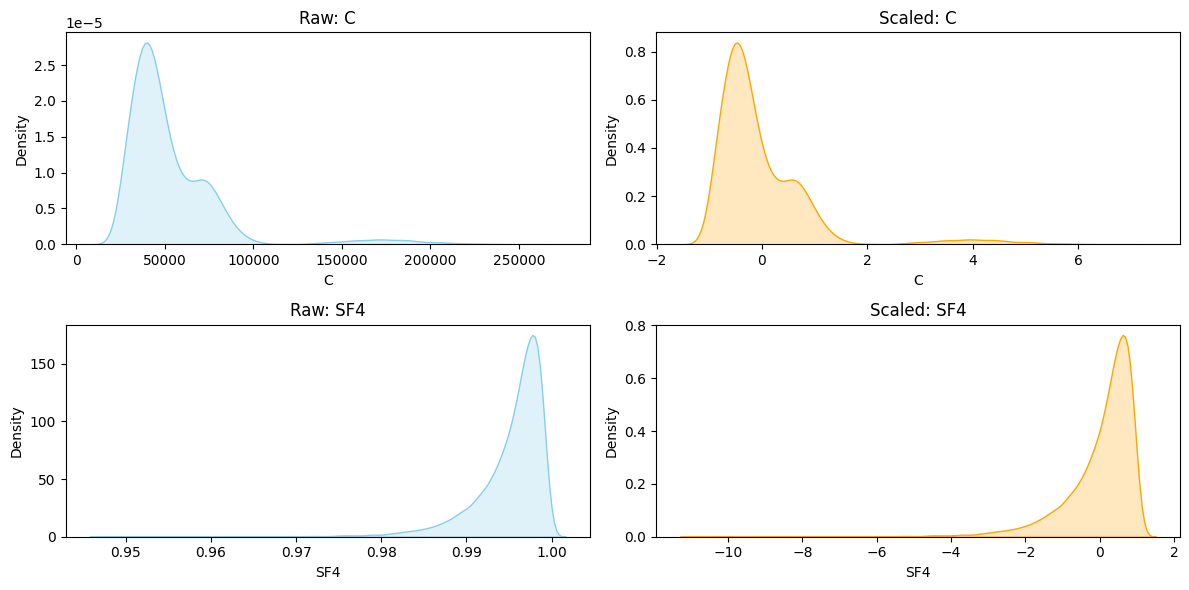

In [ ]:
# -------------------------------------------
# 10. RAW V. SCALED FEATURE DISTRIBUTIONS
# -------------------------------------------

# Distributions remain unchanged, but scaled mean is 0 and variance is 1.
# Pick two features to compare.
features_to_plot = ["C", "SF4"]

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
for i, feature in enumerate(features_to_plot):
    # Raw feature distribution
    sns.kdeplot(df[feature], ax=axes[i][0], fill=True, color="skyblue")
    axes[i][0].set_title(f"Raw: {feature}")
    
    # Scaled feature distribution
    sns.kdeplot(X_scaled[feature], ax=axes[i][1], fill=True, color="orange")
    axes[i][1].set_title(f"Scaled: {feature}")
    
plt.tight_layout()
plt.show()